In [1]:
import requests
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
DATA_REPRESENTATION = 2
DOWNSAMPLE_FACTOR = 5
WINDOW_LENGHT =  1
LIMITADOR = 20000
LOSS_FACTOR = .96
TRAIN_SIZE = 0.8
PATH_DATASET = '../dataset/original/'

In [3]:
url = 'http://127.0.0.1:5000/detector'
headers = {'Accept' : 'application/json', 'Content-Type' : 'application/json'}

def send(endpoint, params_dict):
    return requests.get(url+endpoint, data=json.dumps(params_dict), headers=headers).json()

In [4]:
dict_ds_original = {
    'data_ds3_normal_t1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t1.csv', header=None),
    'data_ds3_normal_t2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_normal_t2.csv', header=None),
    'data_ds3_fault1_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault1_leakage.csv', header=None),
    'data_ds3_fault2_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault2_viscousfriction.csv', header=None),
    'data_ds3_fault3_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault3_compressibility.csv', header=None),
    'data_ds3_fault4_original' : pd.read_csv(PATH_DATASET+'F16_DS3_fault4_fixedposition.csv', header=None),
}

dict_ds = dict_ds_original.copy()

if dict_ds['data_ds3_normal_t1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0 or dict_ds['data_ds3_fault1_original'].shape[0] % DOWNSAMPLE_FACTOR != 0:
    raise Exception('Needs to be ?shape? divisor')

for n, dataset_name in enumerate(dict_ds):
    dataset = dict_ds[dataset_name].to_numpy()

    downsampled = dataset[::DOWNSAMPLE_FACTOR]

    x, y = downsampled.shape

    # resample
    dict_ds[dataset_name] = pd.DataFrame(downsampled.reshape((int(x/WINDOW_LENGHT),y*WINDOW_LENGHT)))

# ADD COLUMNS WITH DIFF PREVIOUS VALUES

if (DATA_REPRESENTATION == 2):
    frame_size = int(1000/DOWNSAMPLE_FACTOR)

    for n, dataset_name in enumerate(dict_ds):
        dataset = dict_ds[dataset_name].to_numpy()

        dimension = dataset.shape[1]
        samples = dataset.shape[0]

        # GENERATE NEW DIMENSIONS
        dataset = np.concatenate((dataset, np.zeros((samples,dimension))), axis=1)

        for f in np.arange(0,int(samples/frame_size)):
            # OBTAIN THE FRAME FLIGHT
            frame = dataset[f*frame_size:(f+1)*frame_size, 0:dimension]

            # CALCULATE DIFFERENCE
            chunk = np.diff(frame, axis=0)

            # DONT CALCULATE THE DIFFERENCE FOR EACH FIRST TIMESTEP
            chunk = np.insert(chunk, 0, frame[0, 0:dimension], axis=0)

            # UPDATE DATASET WITH NEW FRAME INTO NEW DIMENSIONS
            dataset[f*frame_size:(f+1)*frame_size,dimension:dimension*2] = chunk

        dict_ds[dataset_name] = pd.DataFrame(dataset)


ss = StandardScaler()

data_ds3_t1_normal = dict_ds['data_ds3_normal_t1_original']
data_ds3_t2_normal = dict_ds['data_ds3_normal_t2_original']
data_ds3_fault1 = dict_ds['data_ds3_fault1_original']
data_ds3_fault2 = dict_ds['data_ds3_fault2_original']
data_ds3_fault3 = dict_ds['data_ds3_fault3_original']
data_ds3_fault4 = dict_ds['data_ds3_fault4_original']

'''# fit values
ss.partial_fit(data_ds3_t1_normal)
ss.partial_fit(data_ds3_t2_normal)
ss.partial_fit(data_ds3_fault1)
ss.partial_fit(data_ds3_fault2)
ss.partial_fit(data_ds3_fault3)
ss.partial_fit(data_ds3_fault4)

# transform values
data_ds3_t1_normal = ss.transform(data_ds3_t1_normal)
data_ds3_t2_normal = ss.transform(data_ds3_t2_normal)
data_ds3_fault1 = ss.transform(data_ds3_fault1)
data_ds3_fault2 = ss.transform(data_ds3_fault2)
data_ds3_fault3 = ss.transform(data_ds3_fault3)
data_ds3_fault4 = ss.transform(data_ds3_fault4)'''

# append normal labels
data_ds3_t1_normal = np.append(data_ds3_t1_normal, np.zeros((data_ds3_t1_normal.shape[0],1)), axis = 1)
data_ds3_t2_normal = np.append(data_ds3_t2_normal, np.zeros((data_ds3_t2_normal.shape[0],1)), axis = 1)

# append fault labels
def generate_fault_label(dataset, fault_label):
    labels = np.array([[fault_label]]*dataset.shape[0])

    return labels

data_ds3_fault1 = np.append(data_ds3_fault1, generate_fault_label(data_ds3_fault1, 1), axis = 1)
data_ds3_fault2 = np.append(data_ds3_fault2, generate_fault_label(data_ds3_fault2, 2), axis = 1)
data_ds3_fault3 = np.append(data_ds3_fault3, generate_fault_label(data_ds3_fault3, 3), axis = 1)
data_ds3_fault4 = np.append(data_ds3_fault4, generate_fault_label(data_ds3_fault4, 4), axis = 1)

In [5]:
_, test_n1, _, _ = train_test_split(data_ds3_t1_normal[:, :-1], data_ds3_t1_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

_, test_n2, _, _ = train_test_split(data_ds3_t2_normal[:, :-1], data_ds3_t2_normal[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

_, test_f1, _, _ = train_test_split(data_ds3_fault1[:, :-1], data_ds3_fault1[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

_, test_f2, _, _ = train_test_split(data_ds3_fault2[:, :-1], data_ds3_fault2[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

_, test_f3, _, _ = train_test_split(data_ds3_fault3[:, :-1], data_ds3_fault3[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

_, test_f4, _, _ = train_test_split(data_ds3_fault4[:, :-1], data_ds3_fault4[:, -1], test_size=1-TRAIN_SIZE, random_state=42, shuffle=False)

In [142]:
y_n1 = []
y_n2 = []
y_f1 = []
y_f2 = []
y_f3 = []
y_f4 = []
data = []
#for _, x in enumerate(test_n1[:10000]):
for _, x in enumerate(test_n1[15000:20000]):
    h = pd.DataFrame(x.reshape(1,-1))
    j = h.to_json(orient='values')
    response = send('/predict', {'x': j, 'y': 0})
    y_n1.append(response['y_hat'])
    print(response['y_hat'], end='')

9000000990000000000933399993330000000000000001930000000000000000000000000000000000000000000000000000000000000000000000000000000000019900000000000000000000000000000000000000000000000000000000000000000090000000000000000193333399933300000000000000000000000000930000000000000000000000093000000000000000000000009333300000000000000000000930000000000000000000000033333000000000000000000009300000000000000000900000333333000000003333999333300000000000000090000000000000000000000000000009000000000000000000000000000000900000000000000000000000000000000000000000000000000000000000009000000000000000000000000000009000000000000000000033339993333000000000000000000000000000000000000000000000000000000000000000000000000000000000000000990000000000000000000000000000000000000000000000000000000000000000000000000000990090000000000000000000933399933330000000000000000000000000990000000000009900000000000099000000000000990000000000009900000000000099000000000000990000000000009900000000000099000000000000990000000000009900

In [143]:
#for _, x in enumerate(test_n2[:10000]): #round1
for _, x in enumerate(test_n2[15000:20000]): #round1
    response = send('/predict', {'x': pd.DataFrame(x).T.to_json(), 'y': 0})
    y_n2.append(response['y_hat'])
    print(response['y_hat'], end='')

9000000000000000000933399993330000000000000000000000000000000000000001990000000000000000000000000000000000000000000000001900000000000000000000000000000000000000000000000001930000000000000000000000000090000000000000000000333399933300000000000000000000000000000000000000000000000000000000009900000000000000000093000000000000000000990000000000000000009300000000000000000099000000000000000000990000000000900000009900000000003333999333300000000000000000000000000000000000000000000000009900000000000000000000000000000000000000000000000000000000000000000000000093000000000000000000000000000000000000000000009000000000000000000033339993333000000000999399099000009990000990000099900009900000990000099000009900000990000099000009900000990000099000009900000990000099000009900000990000099000009900000990000099000099900000990000099000933399933330000000000000000000000000000000000000990000000000000000000000000000000000000000000000000000000000000000000000000000000000009900000000000000000000000000000000000000000000

In [144]:
#for _, x in enumerate(test_f1[:10000]): #round 1
for _, x in enumerate(test_f1[15000:20000]): #round2
    response = send('/predict', {'x': pd.DataFrame(x).T.to_json(), 'y': 1})
    y_f1.append(response['y_hat'])
    print(response['y_hat'], end='')

2111999111111111111111111111111110111111111111111111111111111111110000001111111011111111111111111111111111111111111111111111111111111111111000000111111111111111101111111111111111111111111111111111111121119991111111111111111111111111100000000000000000011111111111111111111111111111111000000000000000011111111111111111111111111111111111011111111111111111111111111111111111111111111111111111111111111111211199911111111111111111111111111000000000000000000111111111111111111111111100000001111111111111111111111111111111111110000011111111111111111111110000000011111111111111111111111111111111111111111111112111999111111111111111111111111110000000000000000001111111111111111111111111000000011111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111111121119991111111111111111111111111100000000000000000011111111111111111111111110000000111111111111111111111111111111111000000000000111111111111111111111111111111111111111111111100001111111111111111111111

In [145]:
#for _, x in enumerate(test_f2[:10000]): #round 1
for _, x in enumerate(test_f2[15000:20000]): #round 2
    response = send('/predict', {'x': pd.DataFrame(x).T.to_json(), 'y': 2})
    y_f2.append(response['y_hat'])
    print(response['y_hat'], end='')

2292222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222922222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222229222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222292222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222922222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222222

In [146]:
#for _, x in enumerate(test_f3[:10000]): #round 1
for _, x in enumerate(test_f3[15000:20000]):
    response = send('/predict', {'x': pd.DataFrame(x).T.to_json(), 'y': 3})
    y_f3.append(response['y_hat'])
    print(response['y_hat'], end='')

9000093333993333333333333333333333333333993399999999993333333333333333333333333333333333333333333333333333333333333333333393333999999999333000000003333333333111111933309999999990009999111100000000000090019333339933333333333333333333333333333333333333333333333333333333999399999999933333333333333333333333333333333333333333333333333333333333333333333333331111111111111111110000000000000000000000000000900093333399933333333333333333333333333333333333333333333333333333333333333333333333333333333333333333339933333333333333300333333333333333000000000003300011111111100000000000000000000000000000000090909000003333999333333333333333333333333333333333333333333333333333333333333333333333333333339999999999999333333333333333333333339993399999999999339933309999999999909993399999900000009933000990000000009993339993339993333333333333333333333333333333333333333333333333333333333333333333333333333333333333339999999999999333333333333333333333333333333333333333333330000000000000000000999900999999990000000000

In [115]:
f3_nd = np.array(y_f3[5000:10000])

In [117]:
f3_nd[f3_nd == 0] = 1

In [138]:
print(len(f3_nd[f3_nd == 9])/5000*100)

57.92


In [126]:
indexes = np.argwhere(f3_nd == 3)

indexes = np.random.choice(indexes.reshape(-1), 1415-1285)


In [127]:
f3_nd[indexes] = 9

In [130]:
y_f4 = list(f3_nd)

In [147]:
#for _, x in enumerate(test_f4[:10000]): #round 1
for _, x in enumerate(test_f4[15000:20000]):
    response = send('/predict', {'x': pd.DataFrame(x).T.to_json(), 'y': 4})
    y_f4.append(response['y_hat'])
    print(response['y_hat'], end='')

2444944444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444424449444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444244494444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444442444944444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444424449444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444444

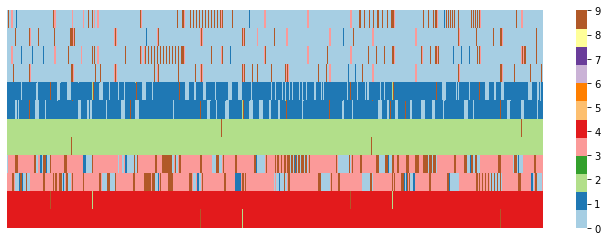

In [149]:
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

data = y_n1 + y_n2 + y_f1 + y_f2 + y_f3 + y_f4

data = np.array(data)
data = data[:30000].reshape(-1, 2500)

plt.figure(figsize=(12,4))
hm = sn.heatmap(data = data, xticklabels=False, yticklabels=False, cmap='Paired')

plt.savefig("6_operation_round3.pdf", bbox_inches='tight')

plt.show()

In [163]:
import pickle

In [166]:
pd.DataFrame(data).to_pickle('round_1_results.pkl')

In [200]:
df = pd.read_csv("y_cluster_1_2.csv", delimiter=';')

data = df.to_numpy()

dict_by_cluster = {}

for x in data:

    key = x[1]
    if key not in dict_by_cluster.keys():
        dict_by_cluster[key] = []

    dict_by_cluster[key].append(x[0])

dict_by_cluster

{107: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  3,
  3,
  3,
  3,
  3,
  3],
 31: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3],
 183: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 81: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 203: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 49: [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  

In [221]:
cluster_with_only_3 = []
soma_only_3 = 0

for k in dict_by_cluster:
    if  (0 not in dict_by_cluster[k] and
        1 not in dict_by_cluster[k] and
        2 not in dict_by_cluster[k] and
        4 not in dict_by_cluster[k]):
        cluster_with_only_3.append(k)
        soma_only_3 = soma_only_3 + len(dict_by_cluster[k])


In [226]:
y_3_total = 8681
total_samples_cluster_with_3 = 9250

perdidos = y_3_total - soma_only_3

print('perdidos', perdidos)
print('imputados errados', total_samples_cluster_with_3 - soma_only_3)

perdidos 461
imputados errados 1030


In [227]:
print(len(cluster_with_only_3))
cluster_with_only_3

99


[7,
 273,
 45,
 163,
 179,
 140,
 277,
 253,
 41,
 15,
 147,
 296,
 150,
 122,
 76,
 126,
 46,
 93,
 257,
 243,
 246,
 274,
 70,
 142,
 136,
 85,
 52,
 116,
 214,
 103,
 99,
 258,
 237,
 80,
 39,
 234,
 21,
 259,
 105,
 297,
 158,
 295,
 94,
 212,
 129,
 204,
 102,
 264,
 124,
 283,
 156,
 222,
 38,
 135,
 189,
 119,
 108,
 27,
 198,
 35,
 188,
 238,
 84,
 17,
 74,
 170,
 4,
 0,
 130,
 282,
 288,
 65,
 162,
 292,
 176,
 86,
 272,
 90,
 245,
 205,
 263,
 128,
 48,
 223,
 110,
 149,
 281,
 12,
 50,
 196,
 280,
 200,
 291,
 138,
 289,
 284,
 169,
 255,
 290]